# Factor trading - Q-Learning

Optimise the return of the portfolio through the value function Q from the input of the factor database

NEED TO IMPLEMENT THE REWARD FUNCTION and the Value function 

## 1. load the libraries and constants

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

import numpy as np
import pandas as pd
import os
import tensorflow as tf
from collections import deque
import random
import matplotlib.pyplot as plt
%matplotlib inline

SOURCE_FOLDER = 'Data-processed'
FACTOR_FOLDER = 'Data-factor'
TARGET_FOLDER = "Output"

DESCRIPTION_FILE = "data_list.csv"
DATA_FILE = "data_content.csv"
RISK_FILE = "data_risk.csv"
FACTOR_FILE = "data_factor.csv"

INVESTMENT = 10000
TRANSACTION_COSTS = 0.001  # 0.1% percent transaction costs 

## 2. load the data

In [3]:
# Load the time-series dataset, the static dataset and the risk dataset. 
df_desc = pd.read_csv(os.path.join(os.getcwd(),SOURCE_FOLDER, DESCRIPTION_FILE),encoding='utf-8',index_col=0)
df_data = pd.read_csv(os.path.join(os.getcwd(),SOURCE_FOLDER, DATA_FILE),encoding='utf-8', index_col=0)
df_risk = pd.read_csv(os.path.join(os.getcwd(),SOURCE_FOLDER, RISK_FILE),encoding='utf-8', index_col=0)
# Load the factor dataset
df_factor = pd.read_csv(os.path.join(os.getcwd(),FACTOR_FOLDER, FACTOR_FILE),encoding='utf-8', index_col=0)

## 3. Factor trading

Train the policy with a Neural Network using first the closing price of the stock and then the factors signals that have been calculated. 

The structure of the network is as follows:
* 256 activations units with ReLu
* Softmax output layer with 3 activations. = buy/sell/hold. 
* Put the rewards. 

get the information about the construction of the rewards/ 

In [8]:
name = 'Q-learning agent'

class Agent:
    """
    Definition of the class Agent. 
    Policy trained from the closing price "-P" or from the factors vector.
    Action are buy +1, sell -1, keep position  = 0
    """
    LAYER_SIZE = 256  # Number of units in the Neural Network
    LEARNING_RATE = 1e-5
    
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        """
        """
        self.state_size = state_size
        self.window_size = window_size  # Nb of history taken to predict the policy
        self.half_window = window_size // 2
        self.trend = trend  # values to feed the placeholder. 
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        """
        """
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    
    def get_state(self, t):
        """
        """
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        """
        """
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        """
        """
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return {"buy": states_buy,
            "sell": states_sell,
            "gains": total_gains,
            "invest":invest}
#         return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        """
        """
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [9]:
close = df_data["-".join(['US22160K1051',"P"])].dropna().values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 20, checkpoint = 10, initial_money = initial_money)

/Users/pierrenowicki/opt/anaconda3/envs/mlbook/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 10, total rewards: 7032.577300.3, cost: 0.243993, total money: 689.788700
epoch: 20, total rewards: 3718.524500.3, cost: 0.074317, total money: 4009.495300


In [10]:
#states_buy, states_sell, total_gains, invest 
array = agent.buy(initial_money = initial_money)

day 4: buy 1 unit at price 37.260000, total balance 9962.740000
day 5: buy 1 unit at price 37.960000, total balance 9924.780000
day 6, sell 1 unit at price 37.700000, investment 1.180891 %, total balance 9962.480000,
day 7: buy 1 unit at price 37.860000, total balance 9924.620000
day 8, sell 1 unit at price 37.040000, investment -2.423604 %, total balance 9961.660000,
day 10, sell 1 unit at price 37.070000, investment -2.086635 %, total balance 9998.730000,
day 12: buy 1 unit at price 36.550000, total balance 9962.180000
day 13, sell 1 unit at price 36.500000, investment -0.136799 %, total balance 9998.680000,
day 15: buy 1 unit at price 37.120000, total balance 9961.560000
day 16, sell 1 unit at price 36.690000, investment -1.158405 %, total balance 9998.250000,
day 17: buy 1 unit at price 36.080000, total balance 9962.170000
day 18, sell 1 unit at price 36.900000, investment 2.272727 %, total balance 9999.070000,
day 19: buy 1 unit at price 36.940000, total balance 9962.130000
day 20

day 493, sell 1 unit at price 49.510000, investment 0.876121 %, total balance 9910.642000,
day 494, sell 1 unit at price 48.750000, investment 0.952578 %, total balance 9959.392000,
day 495: buy 1 unit at price 48.660000, total balance 9910.732000
day 496, sell 1 unit at price 49.220000, investment 1.234060 %, total balance 9959.952000,
day 497: buy 1 unit at price 49.810000, total balance 9910.142000
day 498: buy 1 unit at price 49.840000, total balance 9860.302000
day 499, sell 1 unit at price 49.980000, investment 1.544088 %, total balance 9910.282000,
day 500: buy 1 unit at price 49.770000, total balance 9860.512000
day 501: buy 1 unit at price 50.110000, total balance 9810.402000
day 502, sell 1 unit at price 49.970000, investment 2.692150 %, total balance 9860.372000,
day 503, sell 1 unit at price 49.470000, investment -0.682594 %, total balance 9909.842000,
day 505, sell 1 unit at price 50.080000, investment 0.481541 %, total balance 9959.922000,
day 506, sell 1 unit at price 49

day 980: buy 1 unit at price 66.970000, total balance 9306.187100
day 981, sell 1 unit at price 65.380000, investment -5.574812 %, total balance 9371.567100,
day 983: buy 1 unit at price 66.980000, total balance 9304.587100
day 984: buy 1 unit at price 67.090000, total balance 9237.497100
day 985: buy 1 unit at price 67.400000, total balance 9170.097100
day 986, sell 1 unit at price 66.940000, investment -1.558824 %, total balance 9237.037100,
day 989: buy 1 unit at price 70.830000, total balance 9166.207100
day 990: buy 1 unit at price 71.830000, total balance 9094.377100
day 992, sell 1 unit at price 69.960000, investment 5.171377 %, total balance 9164.337100,
day 993, sell 1 unit at price 70.190000, investment 6.834094 %, total balance 9234.527100,
day 996: buy 1 unit at price 68.170000, total balance 9166.357100
day 997, sell 1 unit at price 68.450000, investment 2.164179 %, total balance 9234.807100,
day 998, sell 1 unit at price 68.400000, investment 1.861504 %, total balance 930

day 1458: buy 1 unit at price 58.480000, total balance 6777.297100
day 1459, sell 1 unit at price 59.230000, investment 45.029383 %, total balance 6836.527100,
day 1460, sell 1 unit at price 59.090000, investment 44.792943 %, total balance 6895.617100,
day 1461, sell 1 unit at price 57.710000, investment 48.050282 %, total balance 6953.327100,
day 1463, sell 1 unit at price 57.810000, investment 50.390219 %, total balance 7011.137100,
day 1464, sell 1 unit at price 57.650000, investment 45.728008 %, total balance 7068.787100,
day 1465, sell 1 unit at price 57.150000, investment 23.274374 %, total balance 7125.937100,
day 1466, sell 1 unit at price 56.720000, investment 19.662447 %, total balance 7182.657100,
day 1467: buy 1 unit at price 57.920000, total balance 7124.737100
day 1468: buy 1 unit at price 56.850000, total balance 7067.887100
day 1469, sell 1 unit at price 57.750000, investment 23.134328 %, total balance 7125.637100,
day 1470, sell 1 unit at price 57.650000, investment 26

day 1855: buy 1 unit at price 82.310000, total balance 6221.359600
day 1856, sell 1 unit at price 82.710000, investment 47.197010 %, total balance 6304.069600,
day 1857, sell 1 unit at price 83.240000, investment 47.327434 %, total balance 6387.309600,
day 1858: buy 1 unit at price 83.860000, total balance 6303.449600
day 1859, sell 1 unit at price 83.400000, investment 44.315626 %, total balance 6386.849600,
day 1860, sell 1 unit at price 82.640000, investment 40.927694 %, total balance 6469.489600,
day 1861: buy 1 unit at price 81.350000, total balance 6388.139600
day 1863: buy 1 unit at price 80.810000, total balance 6307.329600
day 1864: buy 1 unit at price 81.530000, total balance 6225.799600
day 1865: buy 1 unit at price 82.480000, total balance 6143.319600
day 1866, sell 1 unit at price 80.210000, investment 31.083510 %, total balance 6223.529600,
day 1868: buy 1 unit at price 77.810000, total balance 6145.719600
day 1869, sell 1 unit at price 77.690000, investment 24.304000 %, 

day 2233: buy 1 unit at price 94.470000, total balance 4320.672100
day 2235: buy 1 unit at price 95.690000, total balance 4224.982100
day 2237, sell 1 unit at price 97.120000, investment 20.049444 %, total balance 4322.102100,
day 2240: buy 1 unit at price 96.260000, total balance 4225.842100
day 2241, sell 1 unit at price 96.510000, investment 18.170687 %, total balance 4322.352100,
day 2242, sell 1 unit at price 102.580000, investment 24.550753 %, total balance 4424.932100,
day 2243: buy 1 unit at price 101.880000, total balance 4323.052100
day 2244: buy 1 unit at price 103.920000, total balance 4219.132100
day 2245, sell 1 unit at price 104.590000, investment 24.127700 %, total balance 4323.722100,
day 2247: buy 1 unit at price 105.948300, total balance 4217.773800
day 2248, sell 1 unit at price 98.470000, investment 15.547993 %, total balance 4316.243800,
day 2251, sell 1 unit at price 98.310000, investment 17.948410 %, total balance 4414.553800,
day 2252: buy 1 unit at price 97.72

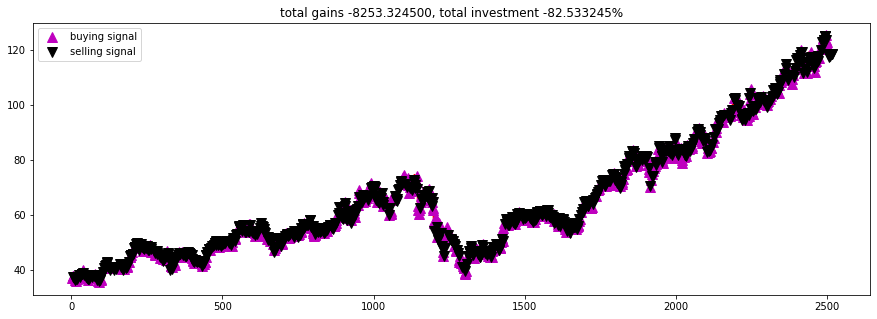

In [11]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = array['buy'])
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = array['sell'])
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig('output/'+name+'.png')
plt.show()

In [ ]:
# Multiple execution 
NB_STOCKS = df_desc[df_desc['TYPE'] == 'Equity'].shape[0] 
invest = INVESTMENT // NB_STOCKS# slipt the amount invested
print(invest)
out  = [ agent.buy(initial_money = invest)
                    for isin in df_desc[df_desc['TYPE'] == 'Equity'].index ]